# BIOE 485 Final Project: Predicting the Severity of Diabetic Retinopathy Disease Using Retinal Scans
### Brendan Brasch & David Ho

## Notebook Instructions
Load the dataset by following these steps:

1. Download the resized diabetic retinopathy dataset here: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized. This should download a file called 'archive.zip'.
2. Extract the zip file to a folder named 'Data'.
3. Move the 'Data' folder into the same directory as this notebook.

The project should now be structured as so:

root_folder/<br>
|-- Final Project.ipynb<br>
|-- Data/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;|-- resized_train/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;|-- resized_train_cropped/<br>
|&nbsp;&nbsp;&nbsp;&nbsp;|-- trainLabels.csv<br>
|&nbsp;&nbsp;&nbsp;&nbsp;|-- trainLabels_cropped.csv<br>

The notebook should now be fully functional to be run (in order). If you want to test different training protocols, you should only need to edit the 'Control Panel' cells!
**You should be able to "Run All" without making any changes to this notebook to run all default training protocols.**

**Warning:** Several of the network configurations in this notebook (especially the prebuilt architectures) can take a **very** long time to train (several hours on GPU). We strongly recommend using a GPU to minimize training time.

## K-Means Clustering Approach

In [1]:
import os
import cv2
import csv
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
# Loads cache file as a dict mapping image names to a NumPy array of
# image data. If no cache file exists, an empty dict is returned.
def load_cache(cache_path):
    if os.path.exists(cache_path):
        return np.load(cache_path, allow_pickle=True).item()
    else:
        return {}

# Returns a NumPy array representing an image when passed the name,
# resized to the desired resolution
def get_image(name, resolution, cache):
    if name in cache:
        return cache[name], cache
    channels = 3
    
    # Resize to output size
    try:
        image_data = np.float32(cv2.imread(image_path + name + '.jpeg')) / 255.0
        output_image = cv2.cvtColor(cv2.resize(image_data, (resolution,resolution)), cv2.COLOR_BGR2GRAY)
        cache[name] = output_image
        return output_image, cache
    except Exception:
        # Return a blank image if there are any loading problems
        image_data = np.zeros((resolution, resolution, channels), dtype=np.float32)
        output_image = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
        cache[name] = output_image
        return output_image, cache

# Returns a dictionary mapping image names to their label
def get_labels(labels_path):
    with open(labels_path, mode='r') as labels_file:
        reader = csv.reader(labels_file)
        next(reader)
        labels = {rows[2]: int(rows[3]) for rows in reader}
        return labels
    
# Returns a list of names of images in the dataset
def get_names(labels_path):
    with open(labels_path, mode='r') as labels_file:
        reader = csv.reader(labels_file)
        next(reader)
        names = [rows[2] for rows in reader]
        return names

# Helper function for plot_dataset()
# Returns 3 lists of widths, heights, and labels for the image dataset
def _analyze_dataset(labels_path):
    names = get_names(labels_path)
    widths = []
    heights = []
    labels = []
    labels_ref = get_labels(labels_path)
    for name in names:
        labels.append(labels_ref[name])
        image_data = np.float32(cv2.imread(image_path + name + '.jpeg')) / 255.0
        try:
            widths.append(image_data.shape[0])
            heights.append(image_data.shape[1])
        except Exception:
            widths.append(0)
            heights.append(0)
    return widths, heights, labels

# Plots histograms of the width, height, and labeling of the image dataset
def plot_dataset(labels_path):
    widths, heights, labels = _analyze_dataset(labels_path)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.hist(widths); plt.xlabel('Width'); plt.ylabel('Occurence'); plt.ylim([0, 36000])
    plt.subplot(1,3,2); plt.hist(heights); plt.xlabel('Height'); plt.ylabel('Occurence'); plt.ylim([0, 36000])
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(1,3,3); plt.hist(labels, 5); plt.xticks(range(5)); plt.xlabel('DR Score'); plt.ylabel('Occurance')
    plt.ylim([0, 36000]); plt.gca().get_yaxis().set_visible(False); plt.show()

In [3]:
# Creates a cache file at the desired path with the specified resolution.
# This file stores a dict mapping image names to a NumPy array of image data.
def make_cache(resolution, cache_path, labels_path):
    names = get_names(labels_path)
    cache = load_cache(cache_path)
    print('Making cache at', cache_path)
    
    # Load each image to add to the cache file
    for name in tqdm(names):
        _, cache = get_image(name, resolution, cache)
    np.save(cache_path, cache)

In [4]:
# Returns the Euclidean (L2) distance between two images
def get_distance(image1, image2):
    distance = np.sum((image1 - image2) ** 2) ** 0.5
    return distance

# Returns the center (or "mean image") as a NumPy array from
# a list of image names
def get_center(image_names, resolution, cache):
    num_images = len(image_names)
    temp_image, _ = get_image(image_names[0], resolution, cache)
    center = np.zeros(temp_image.shape)
    for image_name in image_names:
        image, _ = get_image(image_name, resolution, cache)
        center = center + image
    center = center / num_images
    return center

# Returns a NumPy array of initialized clusters by randomly copying
# an image belonging to each label
def get_starting_clusters(names, labels, labels_reference, resolution, cache):
    temp_image, _ = get_image(names[0], resolution, cache)
    clusters = np.zeros((len(labels), *temp_image.shape))
    labels = list(labels)
    for i in range(len(labels)):
        # Randomly pick images until one is found with the correct label,
        # then store as the mean image for the relevant cluster
        while True:
            name = names[np.random.randint(0, len(names))]
            image_label = labels_reference[name]
            if image_label == labels[i]:
                clusters[i], _ = get_image(name, resolution, cache)
                break
    return clusters

# Returns a count of how many images have been reassigned between two clusters.
# Used to provide progress updates during k-means clustering.
def get_moved_clusters(clusters1, clusters2):
    counter = 0
    for i in range(len(clusters1)):
        for j in range(len(clusters1[i])):
            if clusters1[i][j] not in clusters2[i]:
                counter += 1
    return counter

In [5]:
# Performs k-means clustering on the image dataset and returns the cluster
# as a list of lists, with the nested lists containing the image names.
def k_means_cluster(resolution, cache_path, labels_path):
    start = time.time()
    labels = get_labels(labels_path)
    # Gather all possible label values
    unique_labels = set()
    for _, label in labels.items():
        unique_labels.add(label)
    num_clusters = len(unique_labels)
    names = get_names(labels_path)
    cache = load_cache(cache_path)
    cluster_centers = get_starting_clusters(names, unique_labels, labels, resolution, cache)
    previous_centers = np.zeros(cluster_centers.shape)
    clusters = [[] for i in range(num_clusters)]
    counter = 0

    # Run loop until cluster centers stabilize
    while (previous_centers != cluster_centers).any():
        counter += 1
        print("Iteration", counter)

        # Assign each image to the nearest cluster
        previous_clusters = clusters
        clusters = [[] for i in range(num_clusters)]
        for name in tqdm(names):
            distances = []
            for center in cluster_centers:
                current_image, cache = get_image(name, resolution, cache)
                distances.append(get_distance(current_image, center))
            idx = np.argmin(distances)
            clusters[idx].append(name)

        # Calculate new cluster centers and report progress
        previous_centers = cluster_centers
        cluster_centers = np.zeros(previous_centers.shape)
        distance = 0
        for i in range(num_clusters):
            cluster_centers[i] = get_center(clusters[i], resolution, cache)
            distance += get_distance(cluster_centers[i], previous_centers[i]) / num_clusters
        moved_clusters = get_moved_clusters(clusters, previous_clusters)
        print("Reassigned", moved_clusters, "images into different clusters")
        print("Moved cluster centers an average distance of", distance)
    end = time.time()
    print("Time:", end - start)
    return clusters, cache

In [6]:
# Performs analysis of clustering from the k-means clustering algorithm.
# Specifically, this function calculates the accuracy of assigned clusters,
# plots a heatmap of the confusion matrix scaled to show accuracy for each
# class, prints the raw counts of the confusion matrix, and displays a small
# sample of images from each predicted cluster.
def analyze_clustering(clusters, resolution, cache, labels_path):
    correct = 0
    incorrect = 0
    confusion_mat = np.zeros((len(clusters), len(clusters)))
    scaled_confusion_mat = np.zeros((len(clusters), len(clusters)))
    labels = get_labels(labels_path)
    for predicted_label in range(len(clusters)):
        cluster = clusters[predicted_label]
        for name in cluster:
            actual_label = labels[name]
            if actual_label == predicted_label:
                correct += 1
            else:
                incorrect += 1

            # Store (predicted, actual) label in confusion matrix
            confusion_mat[predicted_label,actual_label] += 1
    print('Accuracy: ', correct / (correct + incorrect))
    for i in range(confusion_mat.shape[1]):
        scaled_confusion_mat[:,i] = confusion_mat[:,i] / np.sum(confusion_mat[:,i])
    plt.figure()
    plt.imshow(scaled_confusion_mat, cmap='hot', vmin=0, vmax=1)
    plt.colorbar(); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.show()
    print(confusion_mat.astype(int))
    
    plt.figure(figsize=(15, 15))
    for i in range(25):
        cluster_num = int(np.floor(i / 5))
        idx = np.random.randint(0, len(clusters[cluster_num]))
        name = clusters[cluster_num][idx]
        image, _ = get_image(name, resolution, cache)
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(image, cmap='Greys')
        title = "Actual: " + str(labels[name]) + ", Predicted: " + str(cluster_num)
        plt.title(title)
    plt.tight_layout()
    plt.show()

### K-Means Clustering Control Panel
You should only need to edit this cell to perform k-means clustering on the dataset.

Making cache at C:\Users\brend\Desktop\Work\Grad\Semester 3\BIOE 485\Final Project/Data/128x128cache.npy


100%|███████████████████████████████████████████████████████████████████████| 35108/35108 [00:00<00:00, 1653123.45it/s]


Iteration 1


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:28<00:00, 1212.10it/s]


Reassigned 35108 images into different clusters
Moved cluster centers an average distance of 8.743160604008628
Iteration 2


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:25<00:00, 1380.92it/s]


Reassigned 2701 images into different clusters
Moved cluster centers an average distance of 1.0936028134306481
Iteration 3


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1006.69it/s]


Reassigned 1845 images into different clusters
Moved cluster centers an average distance of 0.8609426285032105
Iteration 4


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:35<00:00, 1000.33it/s]


Reassigned 1530 images into different clusters
Moved cluster centers an average distance of 0.734284397318581
Iteration 5


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1020.73it/s]


Reassigned 1289 images into different clusters
Moved cluster centers an average distance of 0.623817070966492
Iteration 6


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1003.78it/s]


Reassigned 1109 images into different clusters
Moved cluster centers an average distance of 0.5445093246272333
Iteration 7


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1018.99it/s]


Reassigned 912 images into different clusters
Moved cluster centers an average distance of 0.43207061567937344
Iteration 8


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:35<00:00, 995.79it/s]


Reassigned 805 images into different clusters
Moved cluster centers an average distance of 0.3758909743673385
Iteration 9


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1004.36it/s]


Reassigned 700 images into different clusters
Moved cluster centers an average distance of 0.3261794199123236
Iteration 10


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1015.07it/s]


Reassigned 589 images into different clusters
Moved cluster centers an average distance of 0.27634493776207425
Iteration 11


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1015.10it/s]


Reassigned 478 images into different clusters
Moved cluster centers an average distance of 0.22092700635540008
Iteration 12


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1014.43it/s]


Reassigned 432 images into different clusters
Moved cluster centers an average distance of 0.2002668623424232
Iteration 13


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1007.15it/s]


Reassigned 329 images into different clusters
Moved cluster centers an average distance of 0.15367834952335274
Iteration 14


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1012.88it/s]


Reassigned 270 images into different clusters
Moved cluster centers an average distance of 0.11972868180932147
Iteration 15


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1024.27it/s]


Reassigned 213 images into different clusters
Moved cluster centers an average distance of 0.09502838058798621
Iteration 16


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:35<00:00, 998.90it/s]


Reassigned 188 images into different clusters
Moved cluster centers an average distance of 0.08897936870892512
Iteration 17


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1028.22it/s]


Reassigned 171 images into different clusters
Moved cluster centers an average distance of 0.08245905477957509
Iteration 18


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1012.30it/s]


Reassigned 139 images into different clusters
Moved cluster centers an average distance of 0.06545294665414433
Iteration 19


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1023.77it/s]


Reassigned 125 images into different clusters
Moved cluster centers an average distance of 0.05517465545938273
Iteration 20


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1006.45it/s]


Reassigned 104 images into different clusters
Moved cluster centers an average distance of 0.04830746099770952
Iteration 21


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1030.47it/s]


Reassigned 73 images into different clusters
Moved cluster centers an average distance of 0.03141758301668011
Iteration 22


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1020.54it/s]


Reassigned 47 images into different clusters
Moved cluster centers an average distance of 0.02226328282434
Iteration 23


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:38<00:00, 901.21it/s]


Reassigned 49 images into different clusters
Moved cluster centers an average distance of 0.02513402145833247
Iteration 24


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1020.46it/s]


Reassigned 40 images into different clusters
Moved cluster centers an average distance of 0.016678425486589984
Iteration 25


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 895.71it/s]


Reassigned 40 images into different clusters
Moved cluster centers an average distance of 0.01912714034319263
Iteration 26


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1022.58it/s]


Reassigned 37 images into different clusters
Moved cluster centers an average distance of 0.018637255227054117
Iteration 27


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 896.33it/s]


Reassigned 26 images into different clusters
Moved cluster centers an average distance of 0.01085679414041574
Iteration 28


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1021.38it/s]


Reassigned 23 images into different clusters
Moved cluster centers an average distance of 0.010884502975614548
Iteration 29


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 892.96it/s]


Reassigned 25 images into different clusters
Moved cluster centers an average distance of 0.010655749878786534
Iteration 30


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1023.48it/s]


Reassigned 20 images into different clusters
Moved cluster centers an average distance of 0.010744105319049051
Iteration 31


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 896.74it/s]


Reassigned 17 images into different clusters
Moved cluster centers an average distance of 0.008392911499410377
Iteration 32


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1022.56it/s]


Reassigned 16 images into different clusters
Moved cluster centers an average distance of 0.007536539913994084
Iteration 33


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 896.28it/s]


Reassigned 21 images into different clusters
Moved cluster centers an average distance of 0.008791480083467645
Iteration 34


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1024.64it/s]


Reassigned 16 images into different clusters
Moved cluster centers an average distance of 0.006079223560238469
Iteration 35


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 890.41it/s]


Reassigned 12 images into different clusters
Moved cluster centers an average distance of 0.005837086145441112
Iteration 36


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1025.13it/s]


Reassigned 12 images into different clusters
Moved cluster centers an average distance of 0.0063176276825333815
Iteration 37


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 898.01it/s]


Reassigned 13 images into different clusters
Moved cluster centers an average distance of 0.006866107330483387
Iteration 38


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1025.01it/s]


Reassigned 11 images into different clusters
Moved cluster centers an average distance of 0.006237624100589404
Iteration 39


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 894.65it/s]


Reassigned 9 images into different clusters
Moved cluster centers an average distance of 0.004093138112025359
Iteration 40


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1025.20it/s]


Reassigned 9 images into different clusters
Moved cluster centers an average distance of 0.005037757043472532
Iteration 41


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 894.00it/s]


Reassigned 6 images into different clusters
Moved cluster centers an average distance of 0.004005830435585537
Iteration 42


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1020.80it/s]


Reassigned 6 images into different clusters
Moved cluster centers an average distance of 0.0033573868242159364
Iteration 43


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 896.21it/s]


Reassigned 5 images into different clusters
Moved cluster centers an average distance of 0.0023840772984408494
Iteration 44


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1030.27it/s]


Reassigned 4 images into different clusters
Moved cluster centers an average distance of 0.0020777037733539514
Iteration 45


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 893.50it/s]


Reassigned 8 images into different clusters
Moved cluster centers an average distance of 0.0044162668586302115
Iteration 46


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:35<00:00, 987.61it/s]


Reassigned 9 images into different clusters
Moved cluster centers an average distance of 0.005985526041342388
Iteration 47


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 890.27it/s]


Reassigned 6 images into different clusters
Moved cluster centers an average distance of 0.003529191634009705
Iteration 48


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1017.26it/s]


Reassigned 8 images into different clusters
Moved cluster centers an average distance of 0.0033279621543347475
Iteration 49


100%|███████████████████████████████████████████████████████████████████████████| 35108/35108 [00:39<00:00, 877.71it/s]


Reassigned 2 images into different clusters
Moved cluster centers an average distance of 0.0011032220930387556
Iteration 50


100%|██████████████████████████████████████████████████████████████████████████| 35108/35108 [00:34<00:00, 1018.19it/s]


Reassigned 0 images into different clusters
Moved cluster centers an average distance of 0.0
Time: 2012.3990025520325
Accuracy:  0.15039307280391934


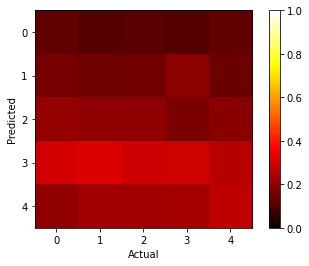

[[3399  271  659   97   93]
 [4139  366  817  167  103]
 [5387  492 1066  147  135]
 [7686  765 1544  257  185]
 [5191  544 1202  204  192]]


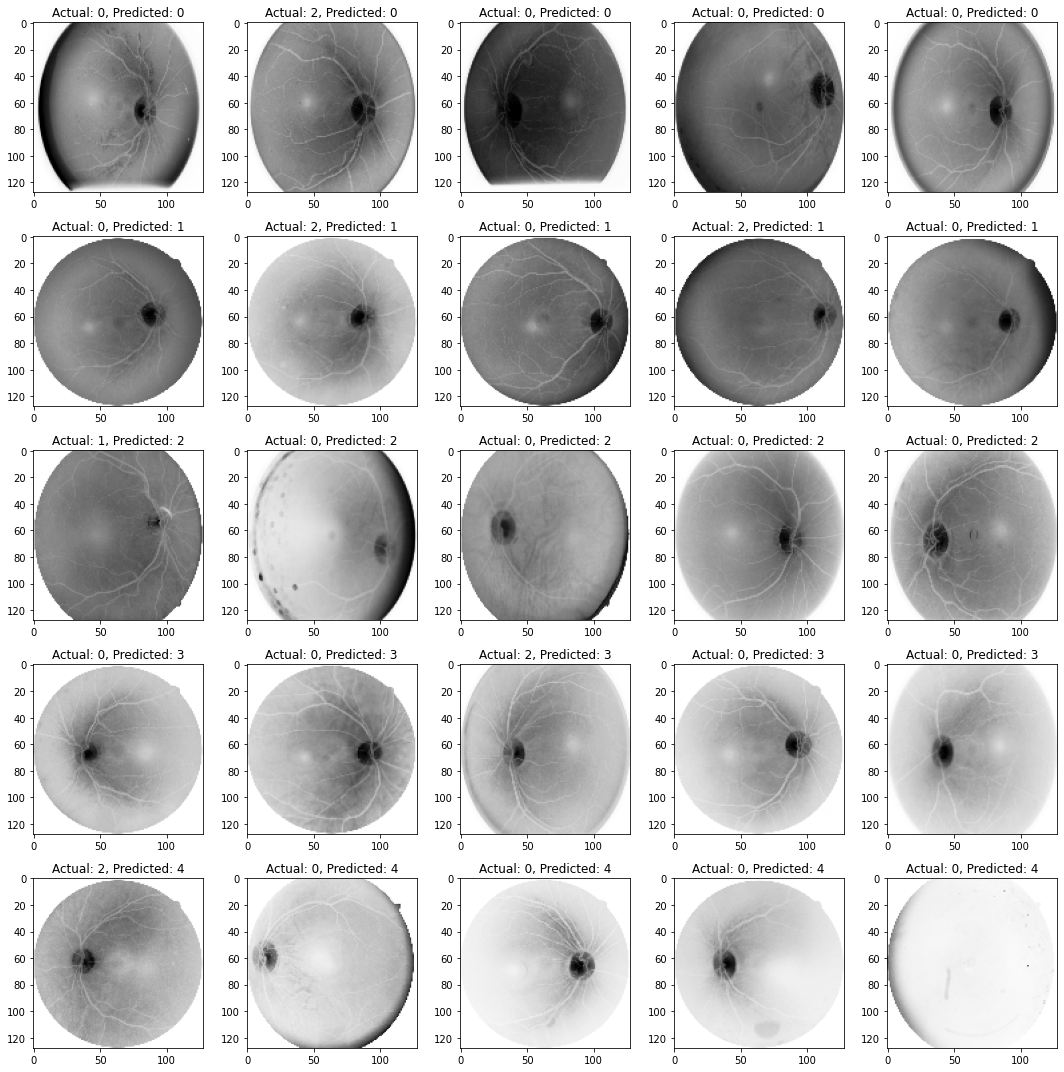

In [7]:
# Define file paths (edit as needed)
image_path = os.getcwd() + '/Data/resized_train_cropped/resized_train_cropped/'
labels_path = os.getcwd() + '/Data/trainLabels_cropped.csv'
cache_path = os.getcwd() + '/Data/128x128cache.npy' # or use '/Data/256x256cache.npy'

# Define variables (edit as needed)
make_cache_file = True # set to true if cache file does not yet exist
analyze_dataset = False # set to true to visualize the dataset before clustering
resolution = 128 # recommended values: [128, 256]

# Perform clustering (no edits needed)
if make_cache_file:
    make_cache(resolution, cache_path, labels_path)
if analyze_dataset:
    plot_dataset(labels_path)
clusters, cache = k_means_cluster(resolution, cache_path, labels_path)
analyze_clustering(clusters, resolution, cache, labels_path)

## Deep Learning Approach

In [8]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import layers
from keras.applications import InceptionV3, VGG19, DenseNet121, Xception

In [9]:
# Makes a TensorFlow compatible dataset in the current directory.
# Images can be labeled for binary classification or categorical
# classification depending on the num_classes input.
def make_tf_dataset(num_classes):
    if num_classes == 2:
        tf_path = os.getcwd() + '/Data/tf_bin/'
    else:
        tf_path = os.getcwd() + '/Data/tf/'
        
    max_width = 1024
    max_height = 1024
    labels = get_labels()
    for image_file in tqdm(os.listdir(image_path)):
        name = image_file.split('.')[0]
        if num_classes == 2:
            label = int(labels[name] != 0)
        else:
            label = labels[name]
        class_dir = tf_path + str(label) + '/'
        if not os.path.isdir(class_dir):
            os.makedirs(class_dir)
        image = Image.open(image_path + image_file)
        width, height = image.size
        output = Image.new(image.mode, (max_width, max_height), (0, 0, 0))
        output.paste(image, (int(max_width / 2 - width / 2), int(max_height / 2 - height / 2)))
        output.save(class_dir + image_file)

In [10]:
# Returns TensorFlow prefetched datasets (split into training and validation).
# This function assumes that the dataset has already been made, otherwise
# an error will be produced.
def get_tf_dataset(image_size, batch_size, num_classes, plot=False):
    tf.get_logger().setLevel('ERROR')
    
    if num_classes == 2:
        image_dir = 'Data/tf_bin/'
    else:
        image_dir = 'Data/tf/'
        
    train_ds, test_ds = keras.preprocessing.image_dataset_from_directory(image_dir, label_mode='int',
        validation_split=0.1, subset='both', seed=6049, image_size=image_size, batch_size=batch_size)
            
    data_augmentation = keras.Sequential([
        layers.RandomFlip(), 
        layers.RandomRotation(0.25, fill_mode='constant'), 
        layers.Rescaling(1.0 / 255)
    ])
    
    augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    augmented_train_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=False), y))
    
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    test_ds = test_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
    
    if plot:
        for ds in [train_ds, test_ds]:
            plt.figure(figsize=(10, 10))
            for images, labels in ds.take(1):
                for i in range(np.min([9, batch_size])):
                    ax = plt.subplot(3, 3, i + 1)
                    plt.imshow(images[i])
                    plt.title(int(labels[i]))
                    plt.axis("off")
            plt.show()
    
    return train_ds, test_ds

In [11]:
# Returns a vector of length num_classes containing the weights for each class.
# These weights are calculated as the inverse of each class' proportion
# in the dataset, normalized to have an average weight of 1.
def get_class_weights(num_classes, labels_path):
    classes = get_labels(labels_path)
    class_counts = np.zeros((num_classes))
    for _, label in classes.items():
        if num_classes == 2:
            class_counts[int(label != 0)] += 1
        else:
            class_counts[label] += 1
    weights_temp = (np.max(class_counts) / class_counts)
    weights_temp = weights_temp * num_classes / np.sum(weights_temp)
    weights = {}
    for i in range(len(weights_temp)):
        weights[i] = weights_temp[i]
    return weights

In [12]:
# Returns a basic model architecture
def make_basic_model(input_shape, num_classes):
    # Define the input layer
    inputs = keras.Input(shape=input_shape + (3,))
    
    # Flatten the input layer to connect to a dense layer
    x = layers.Flatten()(inputs)
    
    # Add a series of dense layers of decreasing size
    for size in [512, 256, 128]:
        x = layers.Dense(size, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
    
    # Define the output layer based on the number of classes
    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid')(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    keras.utils.plot_model(model, show_shapes=True)
    return model

In [13]:
# Returns a convolutional model architecture
def make_conv2d_model(input_shape, num_classes):
    # Define the input layer
    inputs = keras.Input(shape=input_shape + (3,))
    
    # Batch normalize before convolution
    x = layers.BatchNormalization()(inputs)
    
    # Add a series of convolutional layers of increasing filter count
    # Also includes batch normalization, max pooling, and dropout
    for num_filters in [16, 32, 64]:
        x = layers.Conv2D(num_filters, (3, 3), activation='relu', 
                          kernel_regularizer='l1_l2', kernel_initializer='random_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)
        
    # Global average pool the remaining image data and connect some dense layers for interpretation
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    for num_nodes in [512, 256]:
        x = layers.Dense(num_nodes, activation='relu', kernel_regularizer='l1_l2', 
                         kernel_initializer='random_normal')(x)
        x = layers.Dropout(0.25)(x)
    
    # Define the output layer based on the number of classes
    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal')(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax', 
                               kernel_initializer='random_normal')(x)
        
    model = keras.Model(inputs, outputs)
    keras.utils.plot_model(model, show_shapes=True)
    return model

In [14]:
# Returns a pretrained model architecture. The first time each architecture is loaded,
# the ImageNet weights will need to be downloaded, requiring an internet connection.
def make_pretrained_model(input_shape, num_classes, architecture):
    # Define the input layer
    inputs = keras.Input(shape=(input_shape[0], input_shape[1], 3))
    
    # Load the pretrained model architecture and weights
    if architecture == 'InceptionV3':
        preprocessed = keras.applications.inception_v3.preprocess_input(inputs)
        base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=preprocessed)
    elif architecture == 'VGG19':
        preprocessed = keras.applications.vgg19.preprocess_input(inputs)
        base_model = VGG19(include_top=False, weights='imagenet', input_tensor=preprocessed)
    elif architecture == 'DenseNet121':
        preprocessed = keras.applications.densenet.preprocess_input(inputs)
        base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=preprocessed)
    elif architecture == 'Xception':
        preprocessed = keras.applications.xception.preprocess_input(inputs)
        base_model = Xception(include_top=False, weights='imagenet', input_tensor=preprocessed)
    
    # Allow the base model layers to be updated during training
    base_model.trainable = True
        
    # Global average pool the remaining image data and connect a dense layer for interpretation
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.Dropout(0.25)(x)
    
    # Define the output layer based on the number of classes
    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid')(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    keras.utils.plot_model(model, show_shapes=True)
    return model

In [15]:
# Trains the given model according to the input parameters
def train_model(model, epochs, train_ds, test_ds, labels_path, learning_rate, num_classes):
    start = time.time()
    
    # Choose the appropriate loss function for the classification problem
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    
    # Define the SGD optimizer (optionally, the Adadelta optimizer can be specified)
    if learning_rate > 0:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, clipvalue=0.5)
    else:
        optimizer = keras.optimizers.Adadelta()
        
    # Add callbacks to save the model at the end of each epoch and
    # reduce the learning rate by a factor of 5 upon a plateau in validation loss
    callbacks = [
        keras.callbacks.ModelCheckpoint('checkpoints/save_at_{epoch}.keras'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=0, min_delta=0.01)
    ]
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy'],
    )
    weights = get_class_weights(num_classes, labels_path)
    model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=test_ds,
        class_weight=weights,
        shuffle=True
    )
    end = time.time()
    print("Time:", end - start)

In [16]:
# Evaluates the classification ability of a trained model.
# Specifically, this function provides a raw prediction output from the softmax
# or sigmoid output, plots a heatmap of the confusion matrix scaled to show
# accuracy for each class, and prints the raw counts of the confusion matrix.
def evaluate_model(model, test_ds, num_classes):
    raw_predictions = model.predict(test_ds)
    print("Raw prediction example:", raw_predictions[0])
    if num_classes == 2:
        predicted_values = np.round(raw_predictions).astype(int)
    else:
        predicted_values = np.argmax(raw_predictions, axis=1)
    actual_values = []

    val_data = list(test_ds)
    for i in range(len(val_data)):
        for j in range(len(val_data[i][0])):
            actual_values.append(tf.get_static_value(val_data[i][1][j]))
            
    confusion_mat = np.zeros((num_classes, num_classes))
    scaled_confusion_mat = np.zeros((num_classes, num_classes))
    for i in range(len(predicted_values)):
        confusion_mat[predicted_values[i], actual_values[i]] += 1
    for i in range(confusion_mat.shape[1]):
            scaled_confusion_mat[:,i] = confusion_mat[:,i] / np.sum(confusion_mat[:,i])
    plt.figure()
    plt.imshow(scaled_confusion_mat, cmap='hot', vmin=0, vmax=1)
    plt.colorbar()
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    print(confusion_mat.astype(int))

### Simple Neural Network Control Panel
You should only need to edit this cell to train a simple network architecture.

Found 35108 files belonging to 5 classes.
Using 31598 files for training.
Using 3510 files for validation.


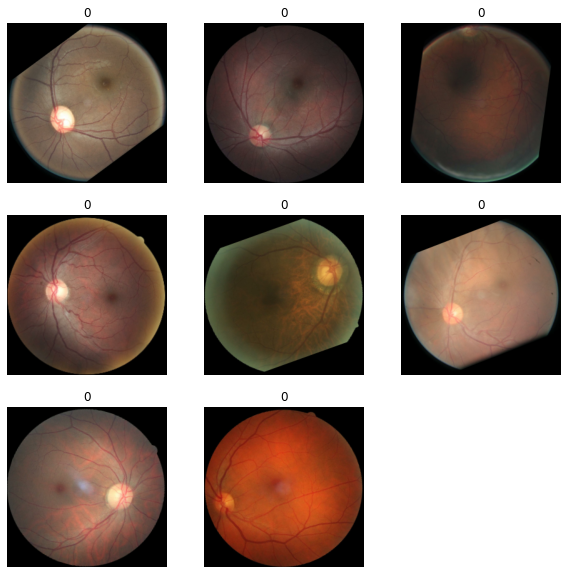

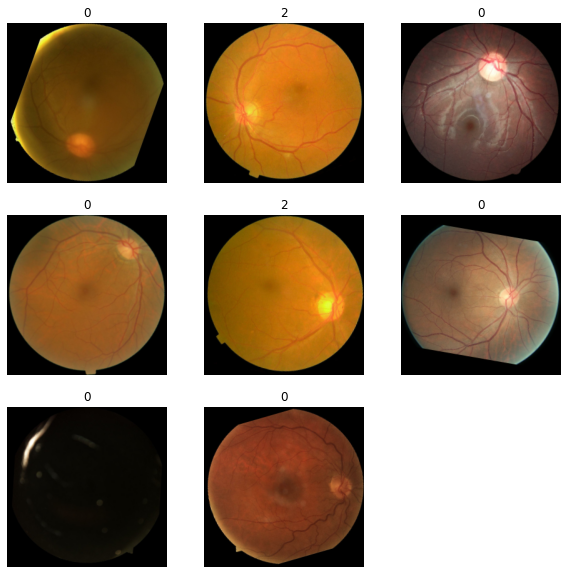

Epoch 1/10
3950/3950 [==============================] - 143s 36ms/step - loss: 0.3676 - accuracy: 0.4793 - val_loss: 1.6053 - val_accuracy: 0.6538 - lr: 1.0000e-04
Epoch 2/10
3950/3950 [==============================] - 141s 36ms/step - loss: 0.3595 - accuracy: 0.6503 - val_loss: 1.6052 - val_accuracy: 0.7205 - lr: 1.0000e-04
Epoch 3/10
3950/3950 [==============================] - 142s 36ms/step - loss: 0.3592 - accuracy: 0.6875 - val_loss: 1.6053 - val_accuracy: 0.7219 - lr: 2.0000e-05
Epoch 4/10
3950/3950 [==============================] - 143s 36ms/step - loss: 0.3592 - accuracy: 0.7061 - val_loss: 1.6054 - val_accuracy: 0.7182 - lr: 4.0000e-06
Epoch 5/10
3950/3950 [==============================] - 140s 35ms/step - loss: 0.3592 - accuracy: 0.7063 - val_loss: 1.6054 - val_accuracy: 0.7202 - lr: 8.0000e-07
Epoch 6/10
3950/3950 [==============================] - 142s 36ms/step - loss: 0.3592 - accuracy: 0.7055 - val_loss: 1.6054 - val_accuracy: 0.7208 - lr: 1.6000e-07
Epoch 7/10
3950/

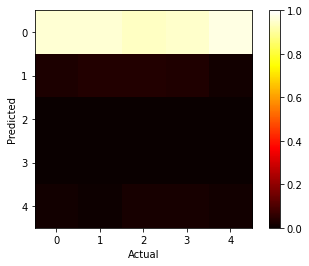

[[2520  199  472   89   69]
 [  76    8   19    3    1]
 [   2    0    1    0    0]
 [   1    0    0    0    0]
 [  36    1   10    2    1]]


In [17]:
# Define file paths (edit as needed)
labels_path = os.getcwd() + '/Data/trainLabels_cropped.csv'

# Define variables (edit as needed)
make_dataset = True # set to True if the tf/ (or tf_bin/ for binary classification) dataset does not exist already
show_sample_data = True # set to True to display a few preprocessed images from the training and validation data

# Define hyperparameters (edit as needed)
image_size = (256, 256)
batch_size = 8
num_classes = 5 # Either 2 or 5 to perform binary or categorical classification, respectively
epochs = 10
learning_rate = 1e-4 # Set to negative value to use Adadelta optimizer without initial learning rate

# Perform training (no edits needed)
if make_dataset:
    make_tf_dataset(num_classes)
train_ds, test_ds = get_tf_dataset(image_size, batch_size, num_classes, plot=show_sample_data)
model = make_basic_model(image_size, num_classes)
train_model(model, epochs, train_ds, test_ds, labels_path, learning_rate, num_classes)
evaluate_model(model, test_ds, num_classes)

### Convolutional Neural Network Control Panel
You should only need to edit this cell to train a convolutional network architecture.

Found 35108 files belonging to 5 classes.
Using 31598 files for training.
Using 3510 files for validation.
Epoch 1/10
3950/3950 [==============================] - 118s 28ms/step - loss: 46.0766 - accuracy: 0.2047 - val_loss: 22.4960 - val_accuracy: 0.0823 - lr: 1.0000e-04
Epoch 2/10
3950/3950 [==============================] - 104s 26ms/step - loss: 10.0433 - accuracy: 0.2099 - val_loss: 4.5358 - val_accuracy: 0.0268 - lr: 1.0000e-04
Epoch 3/10
3950/3950 [==============================] - 103s 26ms/step - loss: 1.4042 - accuracy: 0.0798 - val_loss: 1.7831 - val_accuracy: 0.0593 - lr: 1.0000e-04
Epoch 4/10
3950/3950 [==============================] - 109s 27ms/step - loss: 0.4066 - accuracy: 0.0716 - val_loss: 1.6177 - val_accuracy: 0.0593 - lr: 1.0000e-04
Epoch 5/10
3950/3950 [==============================] - 103s 26ms/step - loss: 0.3620 - accuracy: 0.0706 - val_loss: 1.6143 - val_accuracy: 0.0593 - lr: 1.0000e-04
Epoch 6/10
3950/3950 [==============================] - 103s 26ms/step

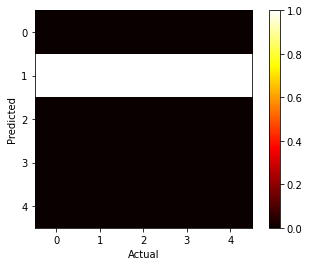

[[   0    0    0    0    0]
 [2635  208  502   94   71]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]


In [18]:
# Define file paths (edit as needed)
labels_path = os.getcwd() + '/Data/trainLabels_cropped.csv'

# Define variables (edit as needed)
make_dataset = False # set to True if the tf/ (or tf_bin/ for binary classification) dataset does not exist already
show_sample_data = False # set to True to display a few preprocessed images from the training and validation data

# Define hyperparameters (edit as needed)
image_size = (256, 256)
batch_size = 8
num_classes = 5 # Either 2 or 5 to perform binary or categorical classification, respectively
epochs = 10
learning_rate = 1e-4 # Set to negative value to use Adadelta optimizer without initial learning rate

# Perform training (no edits needed)
if make_dataset:
    make_tf_dataset(num_classes)
train_ds, test_ds = get_tf_dataset(image_size, batch_size, num_classes, plot=show_sample_data)
model = make_conv2d_model(image_size, num_classes)
train_model(model, epochs, train_ds, test_ds, labels_path, learning_rate, num_classes)
evaluate_model(model, test_ds, num_classes)

### Pretrained Neural Network Control Panel
You should only need to edit this cell to train a pretrained network architecture.

Found 35108 files belonging to 5 classes.
Using 31598 files for training.
Using 3510 files for validation.
Epoch 1/10
3950/3950 [==============================] - 509s 126ms/step - loss: 0.3310 - accuracy: 0.2973 - val_loss: 1.5275 - val_accuracy: 0.2433 - lr: 1.0000e-04
Epoch 2/10
3950/3950 [==============================] - 501s 127ms/step - loss: 0.2861 - accuracy: 0.3555 - val_loss: 0.9851 - val_accuracy: 0.7111 - lr: 1.0000e-04
Epoch 3/10
3950/3950 [==============================] - 501s 127ms/step - loss: 0.2599 - accuracy: 0.3945 - val_loss: 1.8523 - val_accuracy: 0.2060 - lr: 1.0000e-04
Epoch 4/10
3950/3950 [==============================] - 502s 127ms/step - loss: 0.2352 - accuracy: 0.4127 - val_loss: 1.2762 - val_accuracy: 0.3980 - lr: 2.0000e-05
Epoch 5/10
3950/3950 [==============================] - 504s 128ms/step - loss: 0.2278 - accuracy: 0.4237 - val_loss: 1.1882 - val_accuracy: 0.4390 - lr: 4.0000e-06
Epoch 6/10
3950/3950 [==============================] - 504s 128ms/s

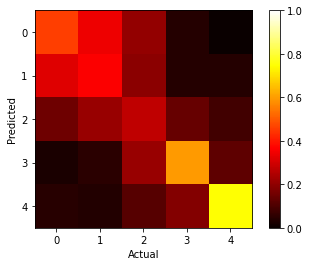

[[1208   71  103    4    0]
 [ 839   75   98    4    3]
 [ 401   44  137   13    6]
 [  67   10  106   56    9]
 [ 120    8   58   17   53]]


In [19]:
# Define file paths (edit as needed)
labels_path = os.getcwd() + '/Data/trainLabels_cropped.csv'

# Define variables (edit as needed)
make_dataset = False # set to True if the tf/ (or tf_bin/ for binary classification) dataset does not exist already
show_sample_data = False # set to True to display a few preprocessed images from the training and validation data

# Define hyperparameters (edit as needed)
image_size = (256, 256)
batch_size = 8
num_classes = 5 # Either 2 or 5 to perform binary or categorical classification, respectively
epochs = 10
learning_rate = 1e-4 # Set to negative value to use Adadelta optimizer without initial learning rate
architecture = 'InceptionV3' # Must be one of ['InceptionV3', 'VGG19', 'DenseNet121', 'Xception']

# Perform training (no edits needed)
if make_dataset:
    make_tf_dataset(num_classes)
train_ds, test_ds = get_tf_dataset(image_size, batch_size, num_classes, plot=show_sample_data)
model = make_pretrained_model(image_size, num_classes, architecture)
train_model(model, epochs, train_ds, test_ds, labels_path, learning_rate, num_classes)
evaluate_model(model, test_ds, num_classes)